This notebook is a modified version of [https://github.com/y0ast/DUE/toy_regression.ipynb](https://github.com/y0ast/DUE/blob/f29c990811fd6a8e76215f17049e6952ef5ea0c9/toy_regression.ipynb)

It primarirly makes the predicted mean value be bounded between 0 and 1 to conform with the dataset that is applied to.

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./DUE')
sys.path.append('./src')
sys.path

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Average, Loss
from ignite.contrib.handlers import ProgressBar

import gpytorch
from gpytorch.mlls import VariationalELBO 
from gpytorch.likelihoods import GaussianLikelihood , LaplaceLikelihood
from gpytorch.constraints import LessThan, Interval

from dkl import DKL, GP, initial_values
from sngp import Laplace
from due.fc_resnet import FCResNet

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette("colorblind")

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


Task:   0%|          | 0/15 [00:00<?, ?it/s]

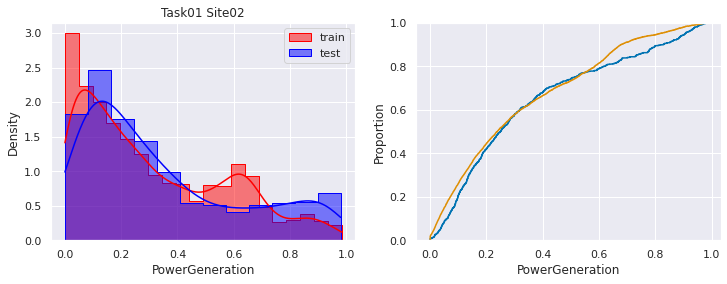

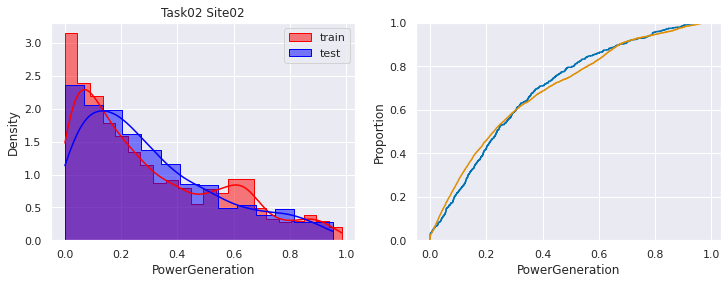

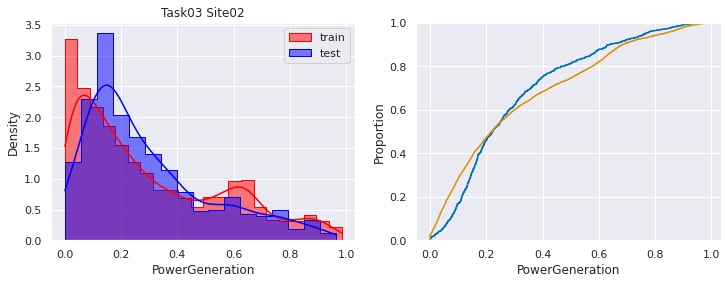

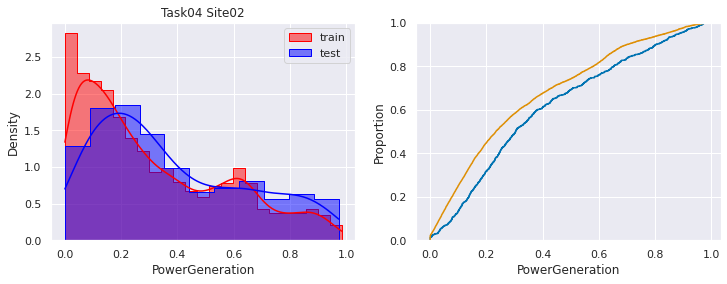

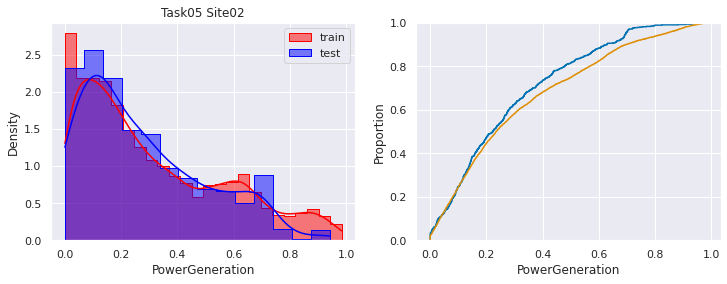

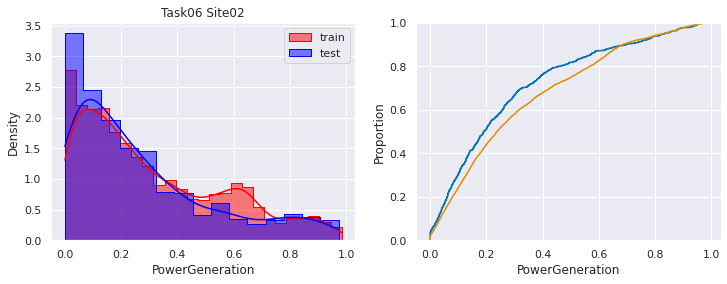

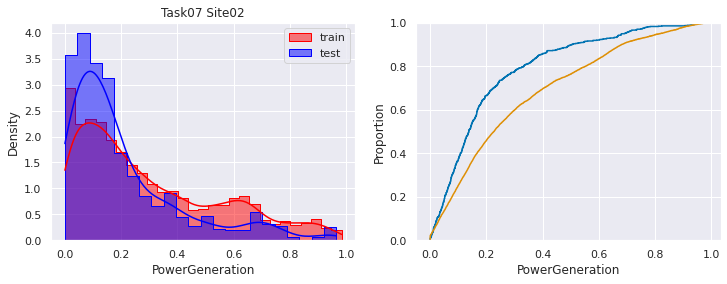

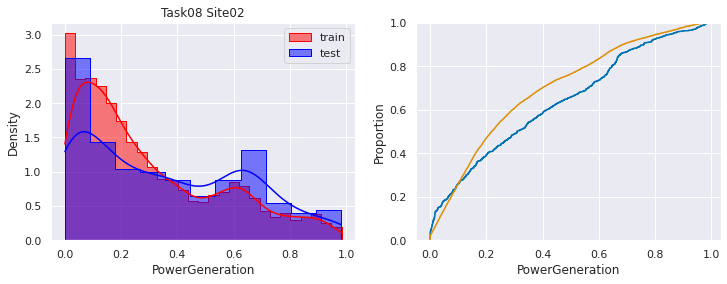

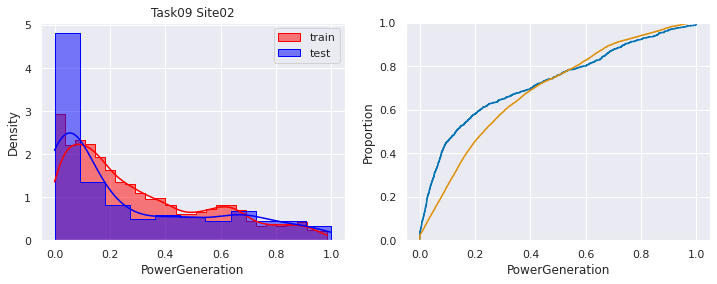

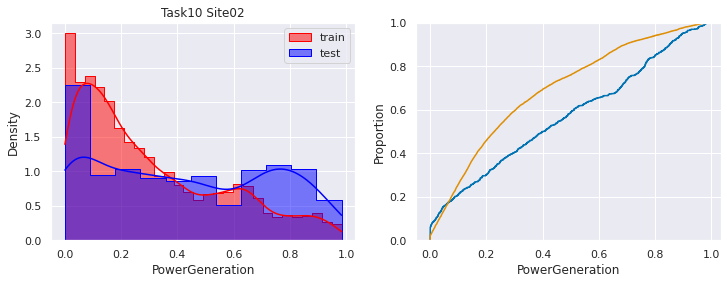

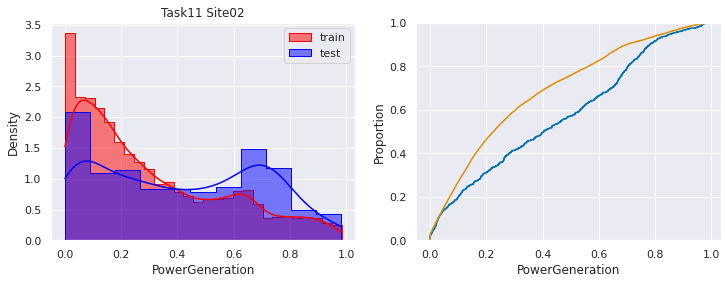

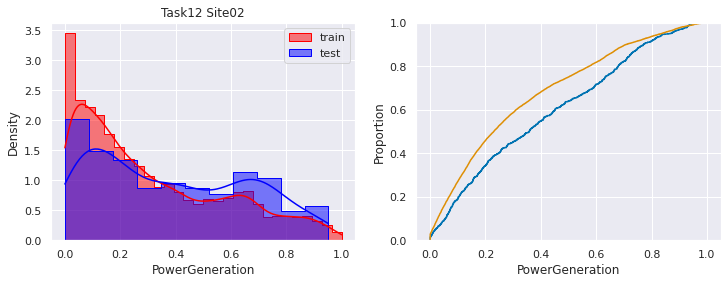

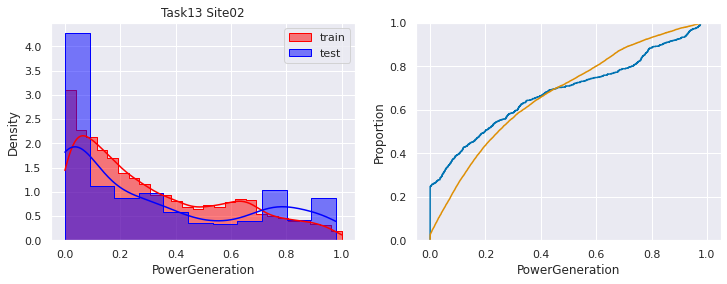

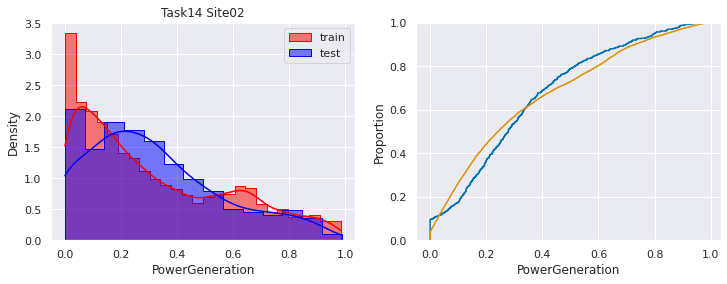

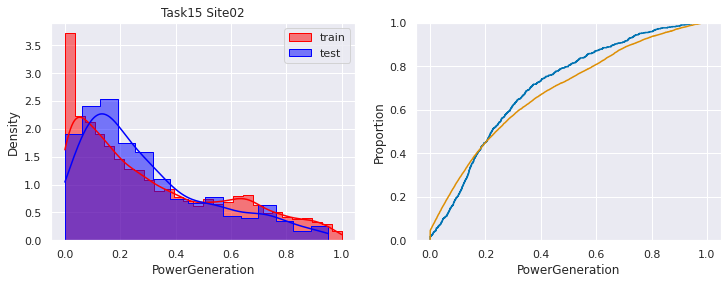

In [2]:
%matplotlib inline

from tqdm.notebook import tqdm

for t in tqdm(range(1,16), desc='Task'):
    for s in range(1,11):
        if s != 2:
            continue
        dateparse = lambda dates: pd.to_datetime(dates)
        df_train = pd.read_csv(f'data/csv/task_{t:02d}_zone_{s:02d}_train.csv',  delimiter=';', index_col='TimeUTC', date_parser=dateparse)
        df_val = pd.read_csv(f'data/csv/task_{t:02d}_zone_{s:02d}_valid.csv',  delimiter=';', index_col='TimeUTC', date_parser=dateparse)
        df_test = pd.read_csv(f'data/csv/task_{t:02d}_zone_{s:02d}_test.csv',  delimiter=';', index_col='TimeUTC', date_parser=dateparse)
        
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        sns.histplot(df_train['PowerGeneration'], ax=axes[0], kde=True, stat='density', element='step', color='red', label='train')
        sns.histplot(df_test['PowerGeneration'], ax=axes[0], kde=True, stat='density', element='step', color='blue', label='test')
        axes[0].set_title(f'Task{t:02d} Site{s:02d}')
        axes[0].legend()
        sns.ecdfplot(df_test['PowerGeneration'], ax=axes[1])
        sns.ecdfplot(df_train['PowerGeneration'], ax=axes[1])
        plt.show()

In [3]:
def power_classification(row):
    if row['PowerGeneration'] < 0.05:
        return 0
    elif row['PowerGeneration'] >= 0.05 and row['PowerGeneration'] < 0.3:
        return 1
    elif row['PowerGeneration'] >= 0.3 and row['PowerGeneration'] < 0.6:
        return 2
    elif row['PowerGeneration'] >= 0.6 and row['PowerGeneration'] < 0.9:
        return 3
    elif row['PowerGeneration'] >= 0.9:
        return 4
    
def power_binary(row):
    if row['PowerGeneration'] < 0.5:
        return 0
    else:
        return 1
    
# df_train['power_class'] = df_train.apply(power_classification, axis=1)
df_train['power_class'] = df_train.apply(power_binary, axis=1)

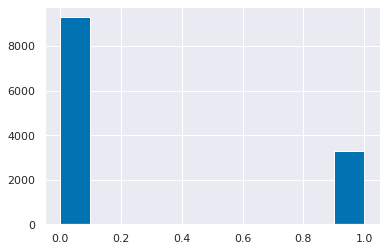

In [4]:
df_train['power_class'].hist()
plt.show()

In [5]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE, SpectralEmbedding


cols = ['WindSpeed10m', 'WindDirection10m', 'WindSpeed100m',
       'WindDirection100m', 'WindEnergy10m', 'WindEnergy100m',
       'WindEnergy100mMean', 'WindDirection100mStd', 'DirectionDifference',
       'EnergyRatio', 'WindEnergy100m_t_m_1', 'WindEnergy100m_t_m_2',
       'WindEnergy100m_t_p_1', 'WindEnergy100m_t_p_2',
       'WindDirection100m_t_p_1', 'WindDirection100m_t_p_2',
       'WindDirection100m_t_m_1', 'WindDirection100m_t_m_2',
       'WindEnergy100mMean_t_p_1', 'WindEnergy100mMean_t_p_2',
       'WindSpeed100m_t_m_2', 'PercentageSpeedChange', 'HourSin', 'HourCos']

# embedding = Isomap(n_components=2)
# embedding = LocallyLinearEmbedding(n_components=2,)
# embedding = TSNE(n_components=2)
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(df_train[cols].values[:1000])
X_transformed.shape

(1000, 2)

In [6]:
data_to_viz = np.concatenate((X_transformed, df_train['power_class'][:1000].values.reshape(-1,1)), axis=1)
data_to_viz = pd.DataFrame(data_to_viz, columns=['Feature 1', 'Feature 2', 'Class'])

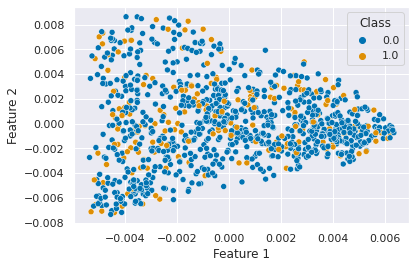

In [7]:
sns.scatterplot(data=data_to_viz, x='Feature 1', y='Feature 2', hue='Class')
plt.show()

In [8]:
dateparse = lambda dates: pd.to_datetime(dates)
df_train = pd.read_csv('data/csv/task_01_zone_01_train.csv',  delimiter=';', index_col='TimeUTC', date_parser=dateparse)
df_val = pd.read_csv('data/csv/task_01_zone_01_valid.csv',  delimiter=';', index_col='TimeUTC', date_parser=dateparse)
df_test = pd.read_csv('data/csv/task_01_zone_01_test.csv',  delimiter=';', index_col='TimeUTC', date_parser=dateparse)


cols = ['WindSpeed10m', 'WindDirection10m', 'WindSpeed100m',
       'WindDirection100m', 'WindEnergy10m', 'WindEnergy100m',
       'WindEnergy100mMean', 'WindDirection100mStd', 'DirectionDifference',
       'EnergyRatio', 'WindEnergy100m_t_m_1', 'WindEnergy100m_t_m_2',
       'WindEnergy100m_t_p_1', 'WindEnergy100m_t_p_2',
       'WindDirection100m_t_p_1', 'WindDirection100m_t_p_2',
       'WindDirection100m_t_m_1', 'WindDirection100m_t_m_2',
       'WindEnergy100mMean_t_p_1', 'WindEnergy100mMean_t_p_2',
       'WindSpeed100m_t_m_2', 'PercentageSpeedChange', 'HourSin', 'HourCos']

X_train, y_train = df_train[cols].values, df_train['PowerGeneration'].values
X_val, y_val = df_val[cols].values, df_val['PowerGeneration'].values
X_test, y_test = df_test[cols].values, df_test['PowerGeneration'].values

In [88]:
torch.manual_seed(0)

batch_size = 128
# X_train, y_train = make_data(n_samples)
# X_test, y_test = X_train, y_train

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=512, shuffle=False)

steps = 5e3
epochs = steps // len(dl_train) + 1
n_samples = len(X_train)
print(f"Training with {n_samples} datapoints for {epochs} epochs")

# Change this boolean to False for SNGP
DUE = False

input_dim = X_train.shape[-1]
features = 128
depth = 4
num_outputs = 1 # regression with 1D output
spectral_normalization = True
coeff = 0.95
n_power_iterations = 1
dropout_rate = 0.01

feature_extractor = FCResNet(
    input_dim=input_dim, 
    features=features, 
    depth=depth, 
    spectral_normalization=spectral_normalization, 
    coeff=coeff, 
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
)

if DUE:
    n_inducing_points = 20
    kernel = "RBF"
    
    initial_inducing_points, initial_lengthscale = initial_values(
            ds_train, feature_extractor, n_inducing_points
    )

    gp = GP(
        num_outputs=num_outputs,
        initial_lengthscale=initial_lengthscale,
        initial_inducing_points=initial_inducing_points,
        kernel=kernel,
    )

    model = DKL(feature_extractor, gp)

    likelihood = GaussianLikelihood()#noise_constraint=LessThan(upper_bound=1.0, transform=torch.nn.Softplus()))
    elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(ds_train))
    loss_fn = lambda x, y: -elbo_fn(x, y)
else:
    num_gp_features = 128
    num_random_features = 1024
    normalize_gp_features = True
    feature_scale = 2
    ridge_penalty = 1
    
    model = Laplace(feature_extractor,
                    features,
                    num_gp_features,
                    normalize_gp_features,
                    num_random_features,
                    num_outputs,
                    len(ds_train),
                    batch_size,
                    ridge_penalty=ridge_penalty,
                    feature_scale=feature_scale,
                    bounded=True,
                   )

    loss_fn = F.mse_loss

if torch.cuda.is_available():
    model = model.cuda()
    if DUE:
        likelihood = likelihood.cuda()
    
lr = 1e-3

parameters = [
    {"params": model.parameters(), "lr": lr},
]

if DUE:
    parameters.append({"params": likelihood.parameters(), "lr": lr})
    
    
optimizer = torch.optim.Adam(parameters)
pbar = ProgressBar()

def step(engine, batch):
    model.train()
    if DUE:
        likelihood.train()
    
    optimizer.zero_grad()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
    
    if not DUE:
        y_pred.squeeze_()

    loss = loss_fn(y_pred, y)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()
    if DUE:
        likelihood.eval()
    
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()

    y_pred = model(x)
            
    return y_pred, y

    
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")
pbar.attach(trainer)

if DUE:
    metric = Loss(lambda y_pred, y: - likelihood.expected_log_prob(y, y_pred).mean())
else:
    metric = Loss(lambda y_pred, y: F.mse_loss(y_pred[0].squeeze(), y))


metric.attach(evaluator, "loss")

@trainer.on(Events.EPOCH_COMPLETED(every=int(epochs/10) + 1))
def log_results(trainer):
    evaluator.run(dl_test)
    print(f"Results - Epoch: {trainer.state.epoch} - "
          f"Test Likelihood: {evaluator.state.metrics['loss']:.2f} - "
          f"Loss: {trainer.state.metrics['loss']:.2f}")

    
if not DUE:
    @trainer.on(Events.EPOCH_STARTED)
    def reset_precision_matrix(trainer):
        model.reset_precision_matrix()

Training with 4920 datapoints for 132.0 epochs


In [89]:
torch.autograd.set_detect_anomaly(True)
trainer.run(dl_train, max_epochs=70)#epochs)

/opt/anaconda3/envs/scml-unc/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

Not Training
Not Training
Results - Epoch: 14 - Test Likelihood: 0.03 - Loss: 0.04


[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

Not Training
Not Training
Results - Epoch: 28 - Test Likelihood: 0.03 - Loss: 0.04


[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

Not Training
Not Training
Results - Epoch: 42 - Test Likelihood: 0.03 - Loss: 0.04


[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

Not Training
Not Training
Results - Epoch: 56 - Test Likelihood: 0.03 - Loss: 0.03


[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

[1/38]   3%|2          [00:00<?]

Not Training
Not Training
Results - Epoch: 70 - Test Likelihood: 0.03 - Loss: 0.03


State:
	iteration: 2660
	epoch: 70
	epoch_length: 38
	max_epochs: 70
	output: 0.02930561639368534
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [90]:
model.eval()
if DUE:
    likelihood.eval()

with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    xx = torch.tensor(X_test).float()
    if torch.cuda.is_available():
        xx = xx.cuda()
    pred = model(xx)

    if DUE:
        ol = likelihood(pred)
        output = ol.mean.cpu()
        output_std = ol.stddev.cpu()
    else:
        output = pred[0].squeeze().cpu()
        output_var = pred[1].diagonal()
        output_std = output_var.sqrt().cpu()

Not Training


In [118]:
def dataframe_to_kerasinput_daily(data, cols, target_variable_name):
    """ create 24 hour input/output mapping aligned with the midnight (1 full day)"""
    X_, y_ = [], []
    for start_date, df in data.groupby(pd.Grouper(freq='D',origin='start_day', offset=pd.Timedelta(1, 'H'))):
        if len(df) == 24:
            X_.append(df[cols].values)
            y_.append(df[target_variable_name].values)
    return np.array(X_), np.array(y_).reshape(-1,24,1)

In [124]:
_, y_test_daily = dataframe_to_kerasinput_daily(df_test, cols, 'PowerGeneration')
y_test_daily = y_test_daily.squeeze()

In [132]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=4, random_state=0).fit(y_test_daily)
kmeans.labels_
# labels = kmeans.predict(y_test_daily)
# kmeans.cluster_centers_

array([0, 0, 2, 3, 0, 0, 0, 0, 0, 3, 1, 3, 0, 2, 3, 1, 0, 0, 0, 3, 1, 2,
       2, 3, 3, 1, 0, 0, 0, 3, 2], dtype=int32)

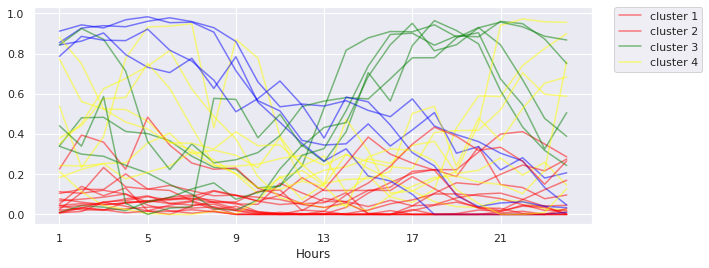

In [163]:
plt.figure(figsize=(10,4))
colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'black']
for i, yt_d in enumerate(y_test_daily):
    plt.plot(yt_d, color=colors[kmeans.labels_[i]], alpha=0.5,)
plt.xticks(range(0,24,4), range(1,25,4), rotation=0)
plt.xlabel('Hours')
plt.legend([f'cluster {i+1}' for i in range(4)], bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.show()

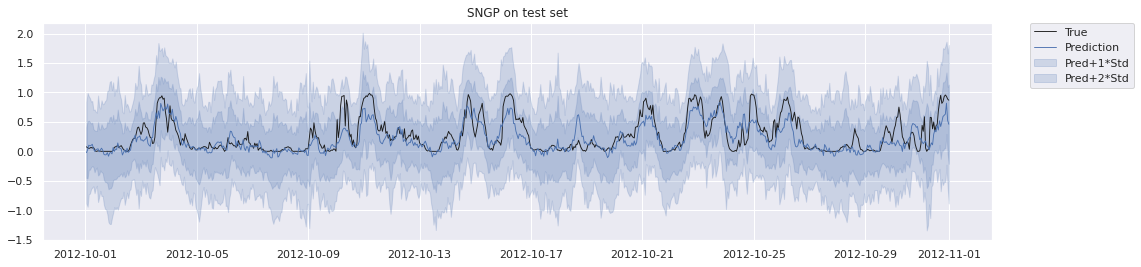

In [101]:
%matplotlib inline
plt.figure(figsize=(17,4))
data_range = df_test.index # range(len(y_test))

plt.fill_between(data_range, output - output_std, output + output_std, alpha=0.2, color='b', label='Pred+1*Std')
plt.fill_between(data_range, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b', label='Pred+2*Std')

plt.plot(data_range, y_test, label='True', color='k', linewidth=0.9)
plt.plot(data_range, output, label='Prediction', color='b', linewidth=0.9)
plt.legend(bbox_to_anchor=(1.15,1), borderaxespad=0)
plt.title(('DUE' if DUE else 'SNGP') + ' on test set')
plt.show()

/opt/anaconda3/envs/scml-unc/lib/python3.8/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


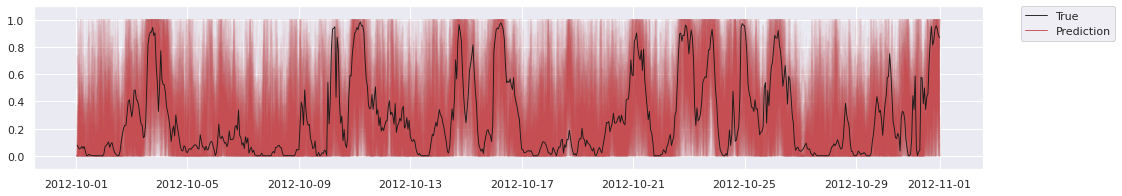

In [112]:
%matplotlib inline

if DUE:
    %matplotlib inline
    scenarios = pred.sample(sample_shape=torch.Size([100]))

    yhat_q95 = np.quantile(scenarios.clip(min=0, max=1), 0.95, axis=0)
    yhat_q05 = np.quantile(scenarios.clip(min=0, max=1), 0.05, axis=0)

    mse = np.sqrt((scenarios.clip(min=0, max=1).mean(axis=0)-y_test)**2).mean()
    mae_scaled = (np.abs(np.quantile(scenarios.clip(min=0, max=1), 0.5, axis=0)-y_test)).mean()/2

    plt.figure(figsize=(17,3))
    plt.plot(range(len(y_test)), y_test, label='True', color='k', linewidth=0.9)
    plt.plot(scenarios.T, color='r', alpha=0.1, linewidth=0.9)
    plt.plot([], [], color='r', label='Prediction', linewidth=0.9)
    # plt.plot(scenarios.clip(min=0, max=1).mean(axis=0), color='b', label='Predicted Mean (Clipped)', linewidth=0.9)
    # plt.fill_between(range(len(y_test)), yhat_q05, yhat_q95, alpha=0.9, color='b', label='PI 90%')
    # plt.plot(scenarios.mean(axis=0), color='blue')

#     plt.title(f'Test data  /  MSE: {mse:2.3f}, Scaled MAE: {mae_scaled:2.3f}')
    plt.ylim([-0.1,1.1])
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.show()
else:
    from scipy.stats import multivariate_normal as mvn
    predicted_mvn = mvn(pred[0].squeeze().cpu().numpy(), pred[1].cpu().numpy(),)
    plt.figure(figsize=(17,3))
    plt.plot(data_range, y_test, label='True', color='k', linewidth=0.9, zorder=100)
    scenarios_sngp = predicted_mvn.rvs(100)
#     plt.plot(data_range, scenarios_sngp.clip(min=0, max=1).mean(axis=0), color='b', zorder=90)
    plt.plot([], [], color='r', label='Prediction', linewidth=0.9)
    plt.plot(data_range, scenarios_sngp.clip(min=0, max=1).T, color='r', alpha=0.05)
    plt.ylim([-0.1,1.1])
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.show()

In [55]:
quantiles = np.linspace(0,1,101)[1:-1]
quantiles

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [29]:
def mean_pinball_loss(y_true, y_pred, alpha):
    """ a generic mean pinball loss implementation that averages out for all instances """
    err = y_true - y_pred
    return np.mean(np.maximum(alpha * err, (alpha - 1) * err), axis=-1)


In [36]:
import numpy as np
import pandas as pd
from numba import guvectorize, float64, int32, njit, cuda, jit

@guvectorize([(float64[:,:], float64[:], float64, float64, float64[:])], '(m,d),(d),(), ()->()')
def ed_calc_fast(x, y, d, b, res):
    """ implementation of the first term of the energy score """
    M = x.shape[0]
    val = 0
    for j in range(M):
        z = (np.sum(np.abs(x[j]-y)**d)**(1/d))**b
        val += z
    res[0] = val/M


@guvectorize([(float64[:,:], int32, float64, float64, float64[:])], '(m,d), (), (), ()->()')
def ei_calc_kband_fast(x, K, d, b, res):
    """ implementation of the second term of the energy score """
    M = x.shape[0]
    K = np.abs(K)
    K = M if K >= M else K
    c = 0
    val = 0
    for j in range(M):
        for k in range(K):
            z = (np.sum(np.abs((x[j]-x[(j+k+1)%M]))**d)**(1/d))**b
            val += z
            c += 1
    val /= c
    res[0] = val


def energy_score_fast(y,x,k,d,b):
    """
        K-band implementation of energy score with parallelization enabled for fast execution on cpu and gpu
        Reference: Multivariate Forecasting Evaluation: On Sensitive and Strictly Proper Scoring Rules (Ziel, Berk)
    """
    return ed_calc_fast(x,y,d,b) - 0.5*ei_calc_kband_fast(x,k,d,b)


In [114]:
if DUE:
    print("DUE scores calculated")
    mse_due = np.sqrt((scenarios.numpy().clip(min=0, max=1).mean(axis=0)-y_test)**2).mean()/2
    mae_due = (np.abs(np.quantile(scenarios.numpy().clip(min=0, max=1), 0.5, axis=0)-y_test)).mean()/2
    qs_due = mean_pinball_loss(y_test.reshape(-1,1), np.quantile(scenarios.numpy(), quantiles, axis=0).T, quantiles).mean()
    es_due = energy_score_fast(y_test, scenarios.numpy(), k=100, d=2, b=1)
else:
    mse_sngp = np.sqrt((scenarios_sngp.clip(min=0, max=1).clip(min=0, max=1).mean(axis=0)-y_test)**2).mean()/2
    mae_sngp = (np.abs(np.quantile(scenarios_sngp.clip(min=0, max=1).clip(min=0, max=1), 0.5, axis=0)-y_test)).mean()/2
    qs_sngp = mean_pinball_loss(y_test.reshape(-1,1), np.quantile(scenarios_sngp.clip(min=0, max=1), quantiles, axis=0).T, quantiles).mean()
    es_sngp = energy_score_fast(y_test, scenarios_sngp.clip(min=0, max=1), k=100, d=2, b=1)

**TODO:**

- truncated normal to get the right output:
  - using mcmc sampler to find the right mean and cov matrices from the obtained normal
  - using truncated marginal normal (easier to do but probably not good at all + losing information for scenarios)
- learn the correct parameters from the very beginning:
  - define the likelihood functions as a dirac-delta mixture of gaussians (in that case laplace approx. seems to be insufficient. next possibility is EM!)
  - 
  

**Questions/Ideas to focus on:**
    
- how out of distribution is defined in regression
- how out of distribution is defined in bounded prediction
- how out of distribution is defined in time-series 

In [58]:
# Inspired by https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
# only works on 1,000 samples

train_x, train_y = torch.tensor(X_train).float(), torch.tensor(y_train).float()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        from dkl import ConstantMeanBounded
        self.mean_module = ConstantMeanBounded()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = GaussianLikelihood()
exact_gp = ExactGPModel(train_x, train_y, likelihood)

exact_gp.train()
likelihood.train()

optimizer = torch.optim.Adam(exact_gp.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, exact_gp)

training_iter = 60

for i in range(training_iter):
    optimizer.zero_grad()
    output = exact_gp(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        exact_gp.covar_module.base_kernel.lengthscale.item(),
        exact_gp.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/60 - Loss: 0.863   lengthscale: 0.693   noise: 0.693
Iter 2/60 - Loss: 0.818   lengthscale: 0.744   noise: 0.644
Iter 3/60 - Loss: 0.770   lengthscale: 0.798   noise: 0.598
Iter 4/60 - Loss: 0.725   lengthscale: 0.853   noise: 0.554
Iter 5/60 - Loss: 0.679   lengthscale: 0.910   noise: 0.513
Iter 6/60 - Loss: 0.636   lengthscale: 0.968   noise: 0.474
Iter 7/60 - Loss: 0.592   lengthscale: 1.026   noise: 0.437
Iter 8/60 - Loss: 0.549   lengthscale: 1.084   noise: 0.402
Iter 9/60 - Loss: 0.510   lengthscale: 1.142   noise: 0.370
Iter 10/60 - Loss: 0.463   lengthscale: 1.200   noise: 0.340
Iter 11/60 - Loss: 0.425   lengthscale: 1.257   noise: 0.311
Iter 12/60 - Loss: 0.382   lengthscale: 1.314   noise: 0.285
Iter 13/60 - Loss: 0.343   lengthscale: 1.368   noise: 0.261
Iter 14/60 - Loss: 0.301   lengthscale: 1.422   noise: 0.238
Iter 15/60 - Loss: 0.259   lengthscale: 1.474   noise: 0.218
Iter 16/60 - Loss: 0.222   lengthscale: 1.524   noise: 0.198
Iter 17/60 - Loss: 0.184   length

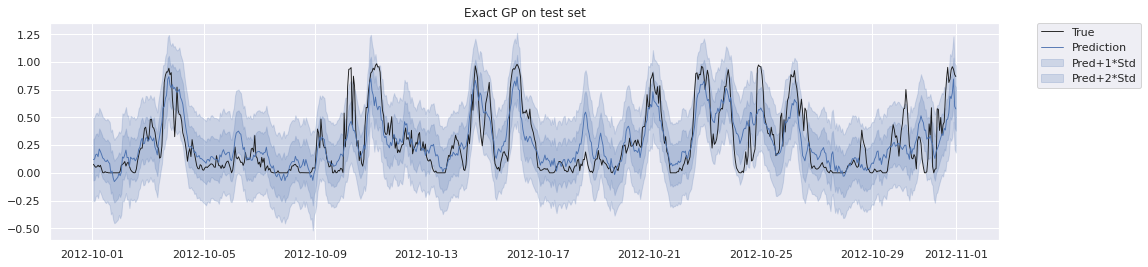

In [59]:
exact_gp.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.tensor(X_test.astype('float32'))
    observed_pred = likelihood(exact_gp(test_x))

    output = observed_pred.mean
    output_std = observed_pred.stddev

plt.figure(figsize=(17,4))
data_range = df_test.index # range(len(y_test))
plt.fill_between(data_range, output - output_std, output + output_std, alpha=0.2, color='b', label='Pred+1*Std')
plt.fill_between(data_range, output - 2 * output_std, output + 2 * output_std, alpha=0.2, color='b', label='Pred+2*Std')

# plt.scatter([], [])
# plt.scatter([], [])
# X_vis, y_vis = make_data(n_samples=300)

# plt.scatter(X_vis.squeeze(), y_vis, facecolors='none', edgecolors='g', linewidth=2)
plt.plot(data_range, y_test, label='True', color='k', linewidth=0.9)
plt.plot(data_range, output, label='Prediction', color='b', linewidth=0.9)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.title('Exact GP on test set')
plt.show()

Col1 |Col2 |Col3
-----|-----|----- 
Data1|Data2|Data3
Data1|Data2|Data3
Data1|Data2|Data3
Data1|Data2|Data3

abc is {{abc}}

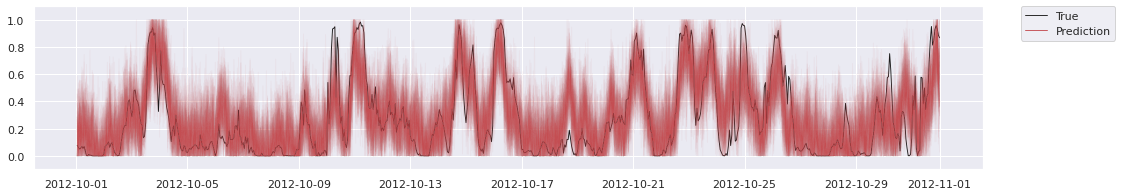

In [83]:
scenarios_exactgp = observed_pred.sample(sample_shape=torch.Size([100]))

yhat_q95 = np.quantile(scenarios_exactgp.clip(min=0, max=1), 0.95, axis=0)
yhat_q05 = np.quantile(scenarios_exactgp.clip(min=0, max=1), 0.05, axis=0)

mse = np.sqrt((scenarios_exactgp.clip(min=0, max=1).mean(axis=0)-y_test)**2).mean()
mae_scaled = (np.abs(np.quantile(scenarios_exactgp.clip(min=0, max=1), 0.5, axis=0)-y_test)).mean()/2

plt.figure(figsize=(17,3))
plt.plot(data_range, y_test, label='True', color='k', linewidth=0.9)
plt.plot(data_range,scenarios_exactgp.clip(min=0, max=1).T, color='r', alpha=0.05, linewidth=0.9)
plt.plot([], [], color='r', label='Prediction', linewidth=0.9)
# plt.plot(scenarios.clip(min=0, max=1).mean(axis=0), color='b', label='Predicted Mean (Clipped)', linewidth=0.9)
# plt.fill_between(range(len(y_test)), yhat_q05, yhat_q95, alpha=0.9, color='b', label='PI 90%')
# plt.plot(scenarios.mean(axis=0), color='blue')

# plt.title(f'Test data  /  MSE: {mse:2.3f}, Scaled MAE: {mae_scaled:2.3f}')
plt.ylim([-0.1,1.1])
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.show()

In [74]:
print("Exact GP scores calculated")
mse_exactgp = np.sqrt((scenarios_exactgp.numpy().clip(min=0, max=1).mean(axis=0)-y_test)**2).mean()/2
mae_exactgp = (np.abs(np.quantile(scenarios_exactgp.numpy().clip(min=0, max=1), 0.5, axis=0)-y_test)).mean()/2
qs_exactgp = mean_pinball_loss(y_test.reshape(-1,1), np.quantile(scenarios_exactgp.numpy(), quantiles, axis=0).T, quantiles).mean()
es_exactgp = energy_score_fast(y_test, scenarios_exactgp.numpy(), k=100, d=2, b=1)


Exact GP scores calculated


In [81]:
mse_bench = np.array(0.1500)
mae_bench = np.array(0.1200)
qs_bench = np.array(0.0900)
es_bench = np.array(5.501)

In [82]:
mse_best = np.array(0.0700)
mae_best = np.array(0.0373)
qs_best = np.array(0.0373)
es_best = np.array(3.112)

| Methods \ Scores | MAE | RMSE | QS | ES
| :- | :-: | :-: | :-: | :-: 
| Benchmark | {{mae_bench.round(3)}} | {{mse_bench.round(3)}} | {{qs_bench.round(3)}} | {{es_bench.round(3)}}
| ExactGP | {{mae_exactgp.round(3)}} | {{mse_exactgp.round(3)}} | {{qs_exactgp.round(3)}} | {{es_exactgp.round(3)}}
| SNGP | {{mae_sngp.round(3)}} | {{mse_sngp.round(3)}} | {{qs_sngp.round(3)}} | {{es_sngp.round(3)}}
| DUE | {{mae_due.round(3)}} | {{mse_due.round(3)}} | {{qs_due.round(3)}} | {{es_due.round(3)}}
| Best on Dataset | {{mae_best.round(3)}} | {{mse_best.round(3)}} | {{qs_best.round(3)}} | {{es_best.round(3)}}